<a href="https://colab.research.google.com/github/hammaad2002/Solar-Irradiance-Forecasting/blob/main/Solar_Irradiance_Forecasting_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://github.com/hammaad2002/Solar-Irradiance-Forecasting.git
!pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

**Reading data in its raw form**

In [3]:
data1 = pd.read_csv('/content/Solar-Irradiance-Forecasting/Solar Irradiance Dataset/2017Solar.csv')

**Displaying top 10 rows of the imported dataset**

In [4]:
data1.head(10)

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,...,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,2829604,-,-,-,29.93,62.78,4,558,4,...,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,unknown
1,Year,Month,Day,Hour,Minute,GHI,Temperature,Dew Point,Relative Humidity,Pressure,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,0,0,0,10.600000000000001,-17.400000000000002,12.290000000000001,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,1,1,0,15,0,10.5,-17.400000000000002,12.370000000000001,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,0,30,0,10.4,-17.400000000000002,12.450000000000001,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2017,1,1,0,45,0,10.200000000000001,-17.3,12.74,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2017,1,1,1,0,0,10.100000000000001,-17.3,12.83,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017,1,1,1,15,0,10,-17.3,12.91,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017,1,1,1,30,0,9.9,-17.3,13,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2017,1,1,1,45,0,9.8,-17.2,13.17,949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see over here that the column names and the first row is basically the meta data of this dataset

In [5]:
print(data1.columns.tolist())
print("Total number of columns:", len(data1.columns.tolist()))

['Source', 'Location ID', 'City', 'State', 'Country', 'Latitude', 'Longitude', 'Time Zone', 'Elevation', 'Local Time Zone', 'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units', 'Dew Point Units', 'DHI Units', 'DNI Units', 'GHI Units', 'Solar Zenith Angle Units', 'Temperature Units', 'Pressure Units', 'Relative Humidity Units', 'Precipitable Water Units', 'Wind Direction Units', 'Wind Speed Units', 'Cloud Type -15', 'Cloud Type 0', 'Cloud Type 1', 'Cloud Type 2', 'Cloud Type 3', 'Cloud Type 4', 'Cloud Type 5', 'Cloud Type 6', 'Cloud Type 7', 'Cloud Type 8', 'Cloud Type 9', 'Cloud Type 10', 'Cloud Type 11', 'Cloud Type 12', 'Fill Flag 0', 'Fill Flag 1', 'Fill Flag 2', 'Fill Flag 3', 'Fill Flag 4', 'Fill Flag 5', 'Surface Albedo Units', 'Version']
Total number of columns: 46


The meta data consists of 46 columns so we will import it separately because we don't wanna work with this

In [6]:
# Assuming your DataFrame is named 'df' and you want to skip the first two rows
num_rows_to_skip = 2
meta_data = pd.read_csv('/content/Solar-Irradiance-Forecasting/Solar Irradiance Dataset/2017Solar.csv', nrows=num_rows_to_skip - 1).to_dict()
meta_data # meta data means data/information about data

{'Source': {0: 'NSRDB'},
 'Location ID': {0: 2829604},
 'City': {0: '-'},
 'State': {0: '-'},
 'Country': {0: '-'},
 'Latitude': {0: 29.93},
 'Longitude': {0: 62.78},
 'Time Zone': {0: 4},
 'Elevation': {0: 558},
 'Local Time Zone': {0: 4},
 'Clearsky DHI Units': {0: 'w/m2'},
 'Clearsky DNI Units': {0: 'w/m2'},
 'Clearsky GHI Units': {0: 'w/m2'},
 'Dew Point Units': {0: 'c'},
 'DHI Units': {0: 'w/m2'},
 'DNI Units': {0: 'w/m2'},
 'GHI Units': {0: 'w/m2'},
 'Solar Zenith Angle Units': {0: 'Degree'},
 'Temperature Units': {0: 'c'},
 'Pressure Units': {0: 'mbar'},
 'Relative Humidity Units': {0: '%'},
 'Precipitable Water Units': {0: 'cm'},
 'Wind Direction Units': {0: 'Degrees'},
 'Wind Speed Units': {0: 'm/s'},
 'Cloud Type -15': {0: nan},
 'Cloud Type 0': {0: 'Clear'},
 'Cloud Type 1': {0: 'Probably Clear'},
 'Cloud Type 2': {0: 'Fog'},
 'Cloud Type 3': {0: 'Water'},
 'Cloud Type 4': {0: 'Super-Cooled Water'},
 'Cloud Type 5': {0: 'Mixed'},
 'Cloud Type 6': {0: 'Opaque Ice'},
 'Cloud T

Now we will read our dataset separately with which we will work further

In [7]:
# Assuming your DataFrame is named 'df'
desired_starting_row = 3
df = pd.read_csv('/content/Solar-Irradiance-Forecasting/Solar Irradiance Dataset/2017Solar.csv', skiprows=desired_starting_row - 1)
df

,Year,Month,Day,Hour,Minute,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,2017,1,1,0,0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,2017,1,1,0,15,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,2017,1,1,0,30,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,2017,1,1,0,45,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,2017,1,1,1,0,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2017,12,31,22,45,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,2017,12,31,23,0,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,2017,12,31,23,15,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,2017,12,31,23,30,0,10.9,-17.4,12.01,949,94,0.7,0.7


Checking for any missing data (if any)

In [8]:
df.isnull().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
Minute                0
GHI                   0
Temperature           0
Dew Point             0
Relative Humidity     0
Pressure              0
Wind Direction        0
Wind Speed            0
Precipitable Water    0
dtype: int64

Thankfully there is not even a single value missing in our dataset so therefore we won't need to worry about cleaning the dataset by applying imputation or interpolation techniques

Now lets list all of our column names so that we can do feature selection (which features to include and which feature to discard) for our model training

In [9]:
df.columns.tolist()

['Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'GHI',
 'Temperature',
 'Dew Point',
 'Relative Humidity',
 'Pressure',
 'Wind Direction',
 'Wind Speed',
 'Precipitable Water']

For model training we won't need time related columns for prediction instead we will use the remaining meteorological columns as our model's features

In [10]:
workingDf = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis = 1)
workingDf

,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...
35035,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,0,10.9,-17.4,12.01,949,94,0.7,0.7


Now we are left with 8 columns out of which GHI is our Solar Irradiance which we will set as our target. So for that reason lets reposition this column to be in the last just to make it easy to interpret.

In [11]:
columns = workingDf.columns.tolist()
columns[0], columns[-1] = columns[-1], columns[0]
workingDf = workingDf[columns]
workingDf

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.7,10.6,-17.4,12.29,949,103,0.7,0
1,0.7,10.5,-17.4,12.37,949,107,0.7,0
2,0.7,10.4,-17.4,12.45,949,111,0.7,0
3,0.7,10.2,-17.3,12.74,949,115,0.7,0
4,0.7,10.1,-17.3,12.83,949,120,0.7,0
...,...,...,...,...,...,...,...,...
35035,0.7,11.2,-17.4,11.78,950,81,0.8,0
35036,0.7,11.1,-17.4,11.86,950,85,0.8,0
35037,0.7,11.0,-17.4,11.93,949,89,0.7,0
35038,0.7,10.9,-17.4,12.01,949,94,0.7,0


Lets plot our target

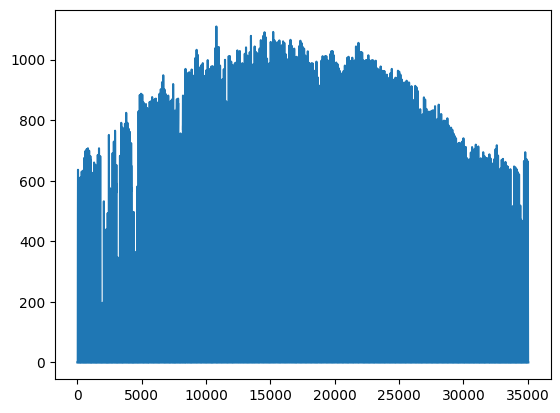

In [12]:
target = workingDf['GHI']
target.plot()
plt.show()

Since this dataset is sampled at 15 min resolution so we will have 4 readings per hour. 

Which will scale to 24 x 4 = 96 readings per day

And this scales to 96 x 365 = 35040 readings every year

And by looking at this dataset we deduce that the solar radiance 'GHI' increases from **January** and reaches its highest value in the mid of the year, most probably in the months of **June & July** in summer (ignoring the outliers) and then start to decrease as we move toward the cold weather at the end of the year. (FOR KARACHI)

Now let's plot the GHI for a one day

In [13]:
random_day = random.randint(1, 365)
random_day

142

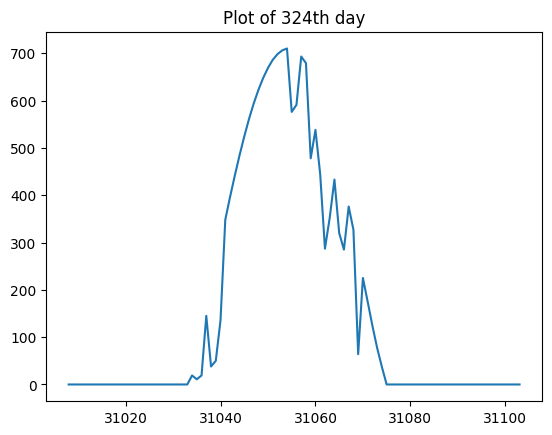

In [14]:
random_day = random.randint(4, 365) # starting from 4th day so that I can write "th" in the title :)
target = workingDf['GHI'][(random_day-1)*96:(random_day*96)]
target.plot()
plt.title(str(f"Plot of {random_day}th day"))
plt.show()

As we expect the plot to be like a bell shape curve, it clearly means that the solar irradiance is at the maximum in mid of day which is 12:00 PM.

Now before using this dataset. Lets normalize it using MinMax normalization which greatly improves the training speed of our model because our Gradient Descent works good on normalized data which leads to faster converge at global minima of loss function.

In [15]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(workingDf), columns=workingDf.columns)
df_normalized.head(10) # this normalizes the data in between range [0, 1]

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.166667,0.291743,0.236287,0.122209,0.633333,0.286111,0.043860,0.0
1,0.166667,0.289908,0.236287,0.123159,0.633333,0.297222,0.043860,0.0
2,0.166667,0.288073,0.236287,0.124109,0.633333,0.308333,0.043860,0.0
3,0.166667,0.284404,0.238397,0.127553,0.633333,0.319444,0.043860,0.0
4,0.166667,0.282569,0.238397,0.128622,0.633333,0.333333,0.043860,0.0
5,0.166667,0.280734,0.238397,0.129572,0.633333,0.344444,0.035088,0.0
6,0.166667,0.278899,0.238397,0.130641,0.633333,0.355556,0.035088,0.0
7,0.166667,0.277064,0.240506,0.132660,0.633333,0.366667,0.035088,0.0
8,0.166667,0.275229,0.240506,0.133729,0.633333,0.377778,0.035088,0.0
9,0.166667,0.273394,0.240506,0.134679,0.633333,0.394444,0.035088,0.0


Let's create our model

First of all let's start with simple RNN

RNN expects input to be of shape [batch, timesteps, features]

In [16]:
class simpleRNN(nn.Module):
    def __init__(self, features = 8, prediction = 1, window = 288, horizon = 1):
        super(simpleRNN, self).__init__()

        #declaring layers of our model
        self.layer1 = nn.RNN(input_size = 8, hidden_size = 1, 
                             num_layers = 1, bias = True, 
                             batch_first = True)
        
        self.activation1 = nn.ReLU()
        
        self.drop1 = nn.Dropout(p=0.2)

        self.layer2 = nn.Linear(in_features = window, out_features = horizon)

        self.activation2 = nn.ReLU()

    def forward(self, x):

        x = self.layer1(x)
        x = self.activation1(x[0])
        x = self.drop1(x)
        x = x.transpose(1, 2)
        x = self.layer2(x)
        x = self.activation1(x)
        return x

Now for timeseries dataset there are 2 things we want to declare first before preparing our dataset in batch.

1.   **Window Length**: meaning the reading of the past the model would be given to make the forecast or prediction.

2.   **Horizon**: how long or how many datapoints ahead we want our model to forecast.



In [17]:
per_day_readings = 4 * 24
window_length = 3 * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                             # and then predict the next 15 minute reading

**Preparing out dataset**

The approach to preparing dataset is using the technique called 'Sliding Window' which is shown below:


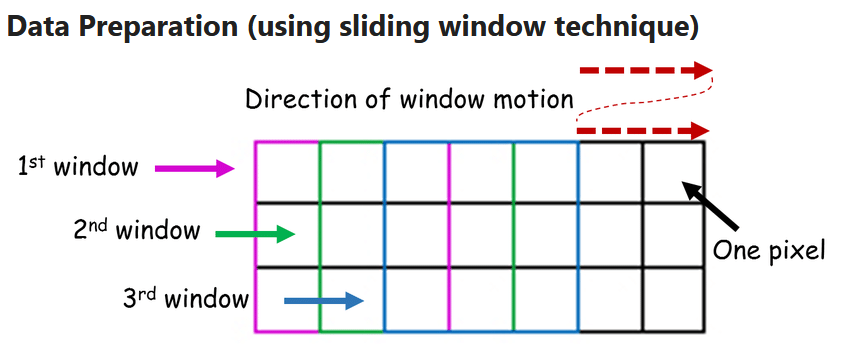

In [18]:
df = df_normalized.values
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ]) #GHI included but its past values only
    y.append(df[window_length+i,-1])                  #next GHI value

  0%|          | 0/34752 [00:00<?, ?it/s]

In [19]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(34752, 288, 8)
(34752,)


In [20]:
x[45]

array([[0.36111111, 0.55779817, 0.50843882, ..., 0.71388889, 0.09649123,
        0.56176736],
       [0.36111111, 0.56330275, 0.50632911, ..., 0.73888889, 0.11403509,
        0.56988278],
       [0.36111111, 0.56697248, 0.50632911, ..., 0.76111111, 0.12280702,
        0.57348963],
       ...,
       [0.33333333, 0.46238532, 0.66666667, ..., 0.45277778, 0.13157895,
        0.50405771],
       [0.33333333, 0.46788991, 0.66666667, ..., 0.66944444, 0.13157895,
        0.52569883],
       [0.33333333, 0.47522936, 0.66666667, ..., 0.88888889, 0.14035088,
        0.54102795]])

In [21]:
y[44]

0.5410279531109107

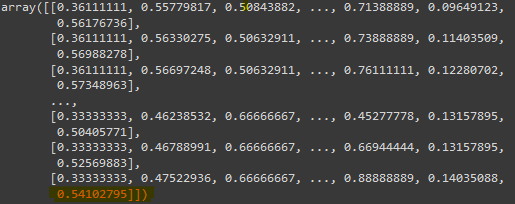

The prediction value (y[44]) is stored in the previous input's value (x[45]).

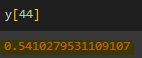

In [22]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
x_train = x[:-per_day_readings*5]
y_train = y[:-per_day_readings*5]
x_test  = x[len(y) - per_day_readings*5:]
y_test  = y[len(y) - per_day_readings*5:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34272, 288, 8)
(34272,)
(480, 288, 8)
(480,)


In [23]:
# finding the device of our environment
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [24]:
# converting our dataset to pytorch tensors for forwarding passing
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

In [25]:
# initializing the model first before training
features = 8
prediction = 1

model = simpleRNN(features = features, prediction = prediction, 
                  window = window_length, horizon = horizon)

In [26]:
model = model.to(device)

In [27]:
amp = True # If we want the model to be trained faster

In [28]:
# Now we towards training the model
if amp:
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Lets define loss function and optimizer
criterion_1 = nn.MSELoss()                                         # MSE
criterion_2 = nn.L1Loss()                                          # MAE (L1)
criterion_3 = MeanAbsoluteError().to(device)                       # MAE
metricc = MeanAbsolutePercentageError().to(device)                 # MAPE metric
optimizer = optim.Adam(model.parameters(), lr=1e-4)                # Adam

num_epochs = 50
batch_size = 128

loss_info = []
metric_info = []

for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0                                             # MAE Loss
    running_metric = 0.0                                           # MAPE metric
    
    for i in tqdm(range(0, len(x_train_tensor), batch_size), desc=f"Epoch {epoch+1}"):

        # Get batch of inputs and targets
        batch_x = x_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)
        
        if amp:

            with torch.autocast(device_type= 'cuda', dtype=torch.float16, enabled=use_amp):
                # Forward pass
                outputs = model(batch_x)
                
                if batch_size == 1:
                    loss = criterion_3(outputs.view(-1), torch.tensor([batch_y]))
                    metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

                else:
                    loss = criterion_3(outputs.view(-1), batch_y)
                    metric = metricc(outputs.view(-1), batch_y)
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 

        else:       

            # Forward pass
            outputs = model(batch_x)

            if batch_size == 1:
              loss = criterion_3(outputs.view(-1), torch.tensor([batch_y]))
              metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

            else:
              loss = criterion_3(outputs.view(-1), batch_y)
              metric = metricc(outputs.view(-1), batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item()
        running_metric += metric.item()

    # Calculate epoch loss and metric
    epoch_loss = running_loss / (len(x_train) / batch_size)
    epoch_metric = running_metric / (len(x_train) / batch_size)
    loss_info.append(epoch_loss)
    metric_info.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.9f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.9f}")
  
print("Training complete!")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: 0.213741881
Epoch 1 MAPE metric: 14068.316728496


Epoch 2:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 2 -------------------------
Epoch 2 MAE loss: 0.125652846
Epoch 2 MAPE metric: 9308.387288451


Epoch 3:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 3 -------------------------
Epoch 3 MAE loss: 0.107542955
Epoch 3 MAPE metric: 5874.107127990


Epoch 4:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 4 -------------------------
Epoch 4 MAE loss: 0.099688446
Epoch 4 MAPE metric: 5155.833276768


Epoch 5:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 5 -------------------------
Epoch 5 MAE loss: 0.095460579
Epoch 5 MAPE metric: 4563.398740052


Epoch 6:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 6 -------------------------
Epoch 6 MAE loss: 0.089888645
Epoch 6 MAPE metric: 4309.197514624


Epoch 7:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 7 -------------------------
Epoch 7 MAE loss: 0.087172115
Epoch 7 MAPE metric: 3866.207866722


Epoch 8:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 8 -------------------------
Epoch 8 MAE loss: 0.085056305
Epoch 8 MAPE metric: 3373.370664904


Epoch 9:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 9 -------------------------
Epoch 9 MAE loss: 0.081433809
Epoch 9 MAPE metric: 3180.225556907


Epoch 10:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 10 -------------------------
Epoch 10 MAE loss: 0.078395269
Epoch 10 MAPE metric: 3170.804273787


Epoch 11:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 11 -------------------------
Epoch 11 MAE loss: 0.075953335
Epoch 11 MAPE metric: 2981.697720869


Epoch 12:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 12 -------------------------
Epoch 12 MAE loss: 0.073983771
Epoch 12 MAPE metric: 2815.831478210


Epoch 13:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 13 -------------------------
Epoch 13 MAE loss: 0.071649016
Epoch 13 MAPE metric: 2732.953430226


Epoch 14:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 14 -------------------------
Epoch 14 MAE loss: 0.069877085
Epoch 14 MAPE metric: 2401.287594320


Epoch 15:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 15 -------------------------
Epoch 15 MAE loss: 0.067774960
Epoch 15 MAPE metric: 2431.654527903


Epoch 16:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 16 -------------------------
Epoch 16 MAE loss: 0.065686213
Epoch 16 MAPE metric: 2182.586139419


Epoch 17:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 17 -------------------------
Epoch 17 MAE loss: 0.064511524
Epoch 17 MAPE metric: 2161.644087739


Epoch 18:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 18 -------------------------
Epoch 18 MAE loss: 0.062809815
Epoch 18 MAPE metric: 2025.127917523


Epoch 19:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 19 -------------------------
Epoch 19 MAE loss: 0.061263909
Epoch 19 MAPE metric: 1945.664267298


Epoch 20:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 20 -------------------------
Epoch 20 MAE loss: 0.060193441
Epoch 20 MAPE metric: 1882.133830014


Epoch 21:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 21 -------------------------
Epoch 21 MAE loss: 0.058855387
Epoch 21 MAPE metric: 1798.319261603


Epoch 22:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 22 -------------------------
Epoch 22 MAE loss: 0.057797910
Epoch 22 MAPE metric: 1652.419609363


Epoch 23:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 23 -------------------------
Epoch 23 MAE loss: 0.056393157
Epoch 23 MAPE metric: 1756.916035279


Epoch 24:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 24 -------------------------
Epoch 24 MAE loss: 0.055489022
Epoch 24 MAPE metric: 1662.609625024


Epoch 25:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 25 -------------------------
Epoch 25 MAE loss: 0.054364511
Epoch 25 MAPE metric: 1632.727297740


Epoch 26:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 26 -------------------------
Epoch 26 MAE loss: 0.053044787
Epoch 26 MAPE metric: 1518.781541515


Epoch 27:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 27 -------------------------
Epoch 27 MAE loss: 0.052497531
Epoch 27 MAPE metric: 1515.786236084


Epoch 28:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 28 -------------------------
Epoch 28 MAE loss: 0.051080189
Epoch 28 MAPE metric: 1424.107245205


Epoch 29:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 29 -------------------------
Epoch 29 MAE loss: 0.050202609
Epoch 29 MAPE metric: 1355.934014447


Epoch 30:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 30 -------------------------
Epoch 30 MAE loss: 0.049392862
Epoch 30 MAPE metric: 1269.696808251


Epoch 31:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 31 -------------------------
Epoch 31 MAE loss: 0.048710770
Epoch 31 MAPE metric: 1287.029172810


Epoch 32:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 32 -------------------------
Epoch 32 MAE loss: 0.048052188
Epoch 32 MAPE metric: 1243.671678575


Epoch 33:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 33 -------------------------
Epoch 33 MAE loss: 0.047316892
Epoch 33 MAPE metric: 1195.937831890


Epoch 34:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 34 -------------------------
Epoch 34 MAE loss: 0.046703160
Epoch 34 MAPE metric: 1164.569030749


Epoch 35:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 35 -------------------------
Epoch 35 MAE loss: 0.045942943
Epoch 35 MAPE metric: 1076.022621369


Epoch 36:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 36 -------------------------
Epoch 36 MAE loss: 0.045716172
Epoch 36 MAPE metric: 1088.505077031


Epoch 37:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 37 -------------------------
Epoch 37 MAE loss: 0.044766343
Epoch 37 MAPE metric: 1031.331232252


Epoch 38:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 38 -------------------------
Epoch 38 MAE loss: 0.044014859
Epoch 38 MAPE metric: 1021.835422193


Epoch 39:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 39 -------------------------
Epoch 39 MAE loss: 0.043605050
Epoch 39 MAPE metric: 987.617658847


Epoch 40:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 40 -------------------------
Epoch 40 MAE loss: 0.042944232
Epoch 40 MAPE metric: 939.745281996


Epoch 41:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 41 -------------------------
Epoch 41 MAE loss: 0.042892675
Epoch 41 MAPE metric: 899.363703987


Epoch 42:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 42 -------------------------
Epoch 42 MAE loss: 0.042249211
Epoch 42 MAPE metric: 903.704848125


Epoch 43:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 43 -------------------------
Epoch 43 MAE loss: 0.041674884
Epoch 43 MAPE metric: 868.164835545


Epoch 44:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 44 -------------------------
Epoch 44 MAE loss: 0.041441545
Epoch 44 MAPE metric: 860.758365609


Epoch 45:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 45 -------------------------
Epoch 45 MAE loss: 0.041308551
Epoch 45 MAPE metric: 829.924911855


Epoch 46:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 46 -------------------------
Epoch 46 MAE loss: 0.040402816
Epoch 46 MAPE metric: 830.149665387


Epoch 47:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 47 -------------------------
Epoch 47 MAE loss: 0.040312077
Epoch 47 MAPE metric: 797.263158298


Epoch 48:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 48 -------------------------
Epoch 48 MAE loss: 0.039812922
Epoch 48 MAPE metric: 822.924626018


Epoch 49:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 49 -------------------------
Epoch 49 MAE loss: 0.039487450
Epoch 49 MAPE metric: 756.815900428


Epoch 50:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 50 -------------------------
Epoch 50 MAE loss: 0.039409857
Epoch 50 MAPE metric: 740.760283859
Training complete!


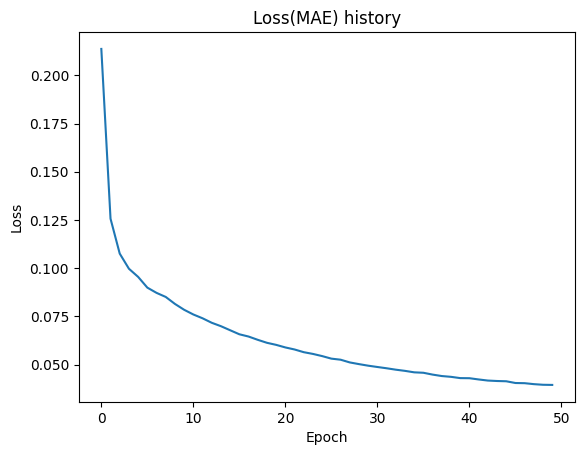

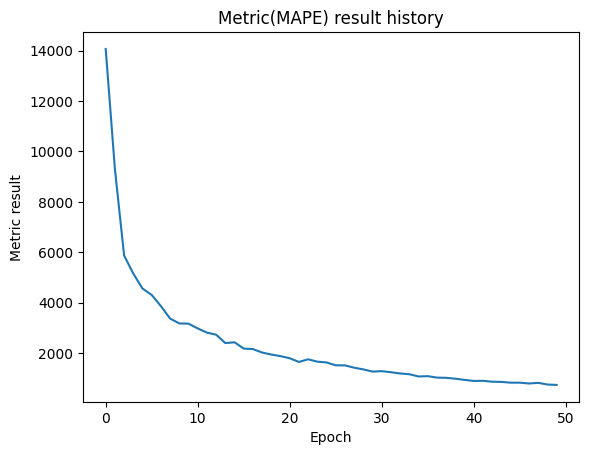

In [29]:
# Plot the history of loss
plt.plot(range(num_epochs), loss_info)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(range(num_epochs), metric_info)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

In [30]:
# Testing model's performance on our dataset
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [31]:
batch_size = 1
modPred = []
GroundTruth = []

In [32]:
running_loss = 0.0                                             # MAE Loss
running_metric = 0.0                                           # MAPE metric

for i in tqdm(range(0, len(x_test_tensor), batch_size), desc=f"Train set inference ..."):
  
        # Get batch of inputs and targets
        batch_x = x_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)

        # Forward pass
        with torch.inference_mode():
            outputs = model(batch_x)

        if batch_size == 1:
            loss = criterion_3(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            metric = metricc(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            modPred.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(torch.tensor([batch_y]).cpu().detach())
        
        else:
            loss = criterion_3(outputs.view(-1), batch_y)
            metric = metricc(outputs.view(-1), batch_y)
            modPred.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(batch_y.cpu().detach())
          
        running_loss += loss.item()
        running_metric += metric.item()

test_loss = running_loss / (len(x_train) / batch_size)
test_metric = running_metric / (len(x_train) / batch_size)
print("-"*25, "TEST LOSS", "-"*25)
print(f"Test MAE loss: {test_loss:.9f}")
print(f"Test MAPE metric: {test_metric:.9f}")

Train set inference ...:   0%|          | 0/480 [00:00<?, ?it/s]

------------------------- TEST LOSS -------------------------
Test MAE loss: 0.000421253
Test MAPE metric: 11.324453639


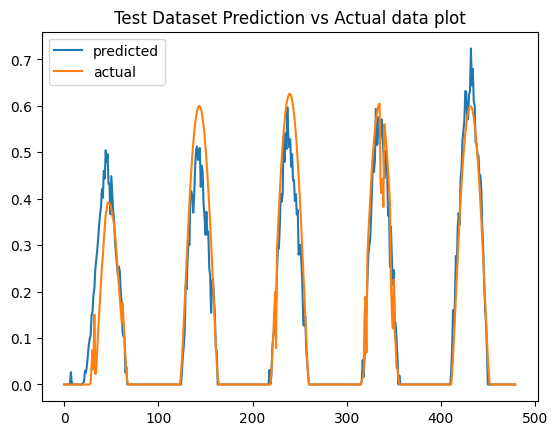

In [33]:
plt.plot(modPred)
plt.plot(GroundTruth)
plt.title('Test Dataset Prediction vs Actual data plot')
plt.legend(['predicted', 'actual'])
plt.show()

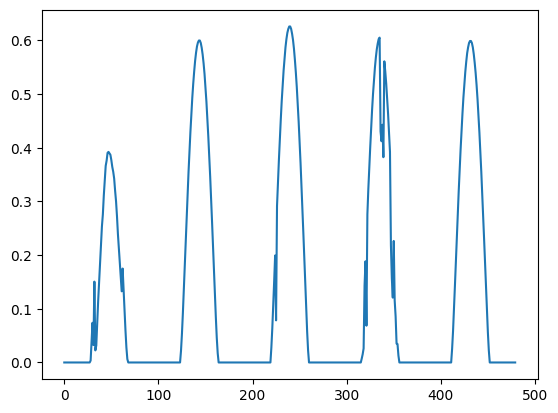

In [34]:
plt.plot(GroundTruth)
plt.show()

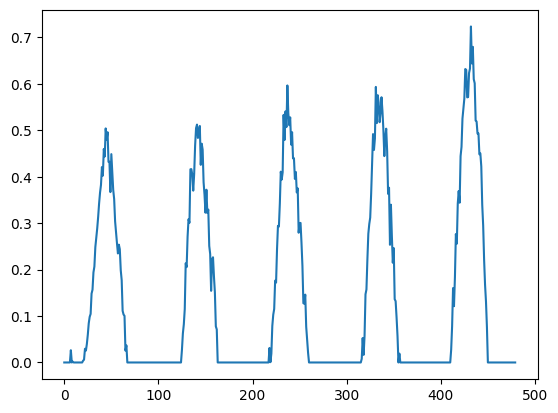

In [35]:
plt.plot(modPred)
plt.show()